In [158]:
import sys
sys.path.append('../modules')  # Replace with the actual path to your module folder


import my_data as dt
import my_placements as mp
import my_networks as mnet
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
import pickle
import random as rd
import ast

np.set_printoptions(suppress=True)

columns = ['id', 'cpu', 'memory', 'storage', 'bandwidth']

In [159]:
def get_topology_nodes(topology='germany'):
    # get topology
    df_nodes, df_edges = dt.get_topology(topology)
    G = mnet.create_graph_topology(df_nodes, df_edges)
    hops = (mnet.floyd_warshall(G, weight='hop'))
    latencies = (mnet.floyd_warshall(G, weight='latency'))
    
    nodes = pd.DataFrame(df_nodes, columns=columns).to_numpy().astype('float')

    return nodes, hops, latencies, G

def get_services_choreog(application='App0'):

    df_services, df_choreog = dt.get_application(application)

    services = pd.DataFrame(df_services, columns=columns).to_numpy().astype('float')
    choreog = pd.DataFrame(df_choreog, columns=['source', 'target', 'payload', 'transmission_time']).to_numpy().astype('float')

    return services, choreog

In [160]:
# DEF read pickle file and return a dictionary
def read_pickle_file(file_name):
    df = pd.read_pickle(file_name)
    return df

In [161]:
def get_dataframe(fuction, dict_lines):

    df = pd.DataFrame(columns=[])
    
    for key, values in dict_lines.items():
        df[key], keys = fuction(values)
    
    # insert keys to df as first column
    df.insert(0, 'app', keys)
    return df

In [162]:
# DEF contagem de nós alocados para cada aplicação
def count_nodes(lines):
    nodes = []
    for key, values in lines.items():
        nodes_for_app = []
        for v in values:
            nodes_for_app.append(v[0])
        # elimiando nós repetidos da lista
        nodes_for_app = list(set(nodes_for_app))
        nodes.append(len(nodes_for_app))

    keys = list(lines.keys())
    return nodes, keys


In [163]:
def count_hops(lines):
    hops_by_app = []
    for key, values in lines.items():
        nodes_allocated = []
        hops_counter = 0
        for v in values:
            nodes_allocated.append(v[0])
        
        for n in range(len(nodes_allocated)-1):
            source = [nodes_allocated[n]][0]
            target = [nodes_allocated[n+1]][0]
            hops_counter += hops[source][target]
        hops_by_app.append(hops_counter)
    keys = list(lines.keys())
    
    return hops_by_app, keys

In [164]:
def get_time_flow(lines):
    time_flow = []
    for key, values in lines.items():
        nodes_allocated = []
        for v in values:
            nodes_allocated.append(v[0])

        time_flows = 0
        for n in range(0, len(nodes_allocated)-1):            
            source = [nodes_allocated[n]][0]
            target = [nodes_allocated[n+1]][0]
            
            time_flows += (dict_coreog[[key][0]][0][n, 2]*latencies[source][target])/1500
        
        # format time_flows to 6 decimal places
        time_flows = float("{:.6f}".format(time_flows))
        time_flow.append(time_flows)
    keys = list(lines.keys())
        
    return time_flow, keys


In [165]:
# DEF Calculado a utilização de CPU, memória e armazenamento para cada aplicação
def get_nodes_utilization(lines):

    services_placed = []
    nodes_utilization = []

    # nodes to list
    nodes_list = list(nodes)

    for key, values in lines.items():
        services_placed, choreog = get_services_choreog(folder+key)
        nodes_allocated = []
        nodes_allocated.append([v[0] for v in values])
        all_service, all_node = 0, 0
        
        nodes_allocated_data = []
        for nds in nodes_allocated:
            for n in list(set(nds)):
                nodes_allocated_data.append(nodes_list[n])

        all_service = np.sum(services_placed, axis=0)
        all_node = np.sum(nodes_allocated_data, axis=0)
        
        nodes_utilization.append(np.sum((all_service[1:])) / np.sum(all_node[1:]))

    keys = list(lines.keys())

    return nodes_utilization, keys

In [166]:
def plot_grouped_bar_chart(dataframe, file,title, xlable, ylabel):

    plt.style.use('ggplot')

    # Extracting labels and data from the dataframe
    labels = dataframe.iloc[:, 0].copy()
    data = dataframe.iloc[:, 1:]

    for i, l in enumerate(labels):
        labels[i] = str(len(dict_apps[l][0]))

    # Setting the positions and width for the bars
    bar_width = 0.2
    positions = np.arange(len(labels))


    # Plotting each set of bars
    # fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(10,5))
    for i, col in enumerate(data.columns):
        ax.bar(positions + i * bar_width, data[col], bar_width, label=col)

    # Adding labels, title, and legend
    ax.set_xlabel(xlable)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(positions + bar_width * (len(data.columns) - 1) / 2)
    ax.set_xticklabels(labels)
    ax.legend()

    # Assuming your dataframe is named 'df'
    matrix = dataframe.iloc[:, 1:].values

    # Get the minimum and maximum values
    # min_value = np.min(matrix)
    max_value = np.max(matrix)
    
    # ax.set_ylim(0, dataframe.iloc[:,1].max()+dataframe.iloc[:,1].min())
    ax.set_ylim(0, max_value*1.2)

    # Show the plot
    ax.legend(ncol=3)
    # plt.xticks(rotation=90)
    plt.show()
    # plt.savefig('graphs/'+file+'.svg', format='svg')



In [167]:
def get_consolidate_data(df_data):

    dict_placements = dict()
    for i in range(len(df_data)):
        placement, time = ast.literal_eval(df_data.iloc[i][1])
        dict_placements[df_data.iloc[i][0]] = placement

    return dict_placements

In [168]:
folder = 'orign/'
topology = 'germany'
solution = 'heuristics'

model = 'm3'

sol = {
    'm1': 'M-1',
    'm2': 'M-2',
    'm3': 'M-3',
}


In [169]:
app_services = []
dict_apps = dict()
dict_coreog = dict()
nodes, hops, latencies, G = get_topology_nodes(topology=topology)

for i in range(20):

    services, choreog = get_services_choreog(application=folder+'App'+str(i))

    app_services.append(len(services))
    dict_apps['App'+str(i)] = [services[:, 0].astype('int')]
    dict_coreog['App'+str(i)] = [choreog.astype('int')]

In [170]:
# open placements results data
cp = 100
dict_lines = dict()

# sort a number between 1 and 100
choice = rd.randint(1, 100)

# HERISTIC
df_data = pd.read_csv('heuristics/results/'+topology+'/'+model+'/csv/heuristic_'+str(choice)+'.csv', header=None)
dict_lines[model+'_heuristic'] = get_consolidate_data(df_data)

# LP
# M-1 ou M-2
# df_data = pd.read_csv('linear_programm/results/'+topology+'/'+model+'_linear_exp_'+topology+'.csv', header=None)
# M-3
df_data = pd.read_csv('linear_programm/results/'+topology+'/'+model+'_linear_exp_'+topology+'_1min.csv', header=None)
dict_lines[model+'_linear'] = get_consolidate_data(df_data)

print('heuristics/results/'+topology+'/'+model+'/csv/heuristic_'+str(choice)+'.csv')
print('linear_programm/results/'+topology+'/'+model+'_linear_exp_'+topology+'.csv')

heuristics/results/germany/m2/csv/heuristic_28.csv
linear_programm/results/germany/m2_linear_exp_germany.csv


In [171]:
for key, values in dict_lines.items():
    for k, v in values.items():
        v.sort(key=lambda x: x[1])

In [172]:
df_nodes_for_app = get_dataframe(count_nodes, dict_lines)

df_hops_app = get_dataframe(count_hops, dict_lines)

df_latencies = get_dataframe(get_time_flow, dict_lines)

df_nodes_utilization = get_dataframe(get_nodes_utilization, dict_lines)

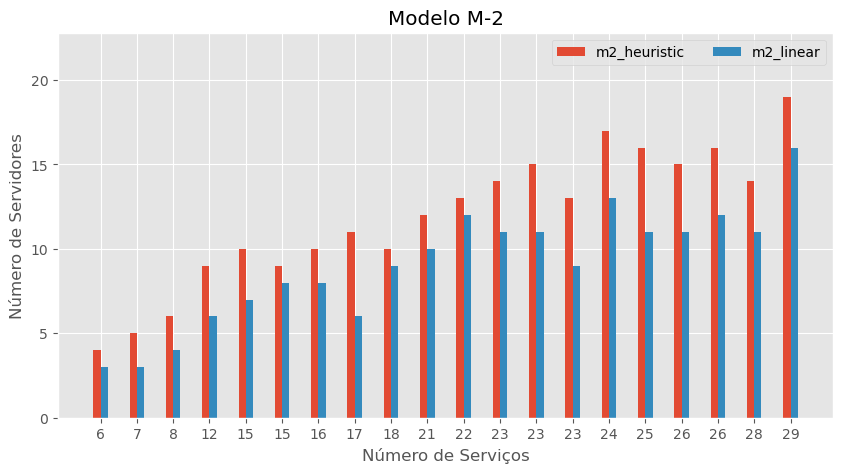

In [173]:

plot_grouped_bar_chart(df_nodes_for_app, model+'_solution_nodes_allocated','Modelo '+sol[model], 'Número de Serviços', 'Número de Servidores')

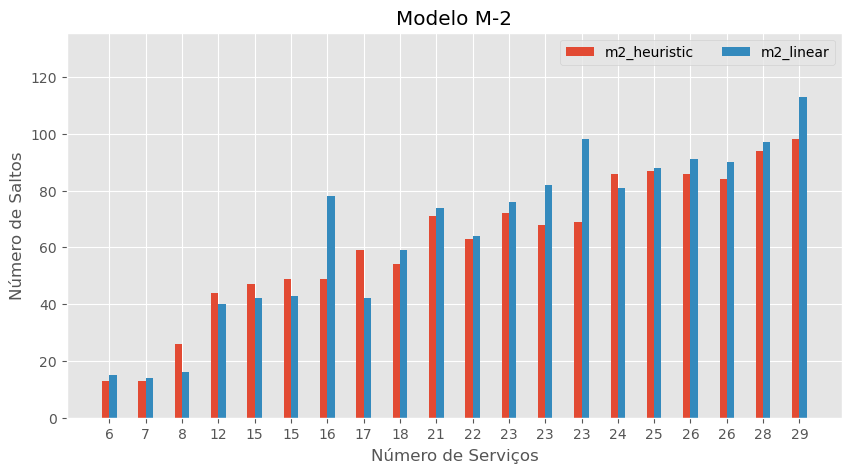

In [174]:
# plot_line_graph(df_hops_app, 'Number of hops for each application', ylabel='Number of hops')
plot_grouped_bar_chart(df_hops_app, model+'_solution_nodes_hops','Modelo '+sol[model], 'Número de Serviços', 'Número de Saltos')


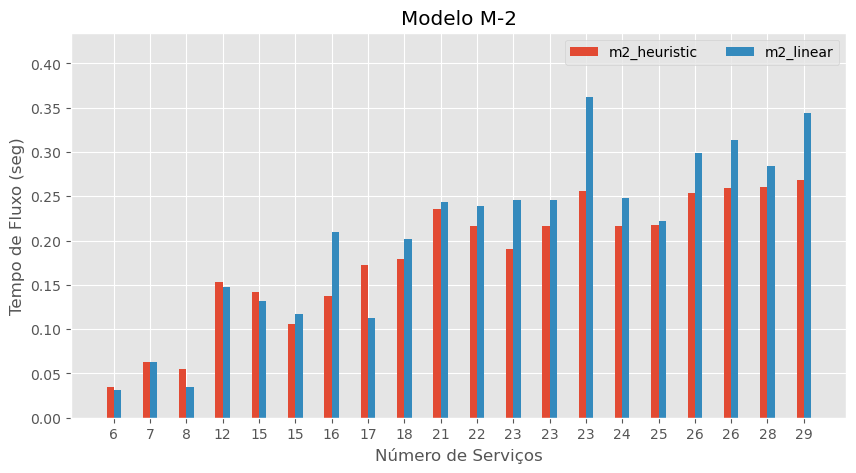

In [175]:
# plot_line_graph(df_latencies, 'Time Flow for each application', ylabel='Time Flow (s)')
plot_grouped_bar_chart(df_latencies, model+'_solution_time_flow','Modelo '+sol[model], 'Número de Serviços', 'Tempo de Fluxo (seg)')


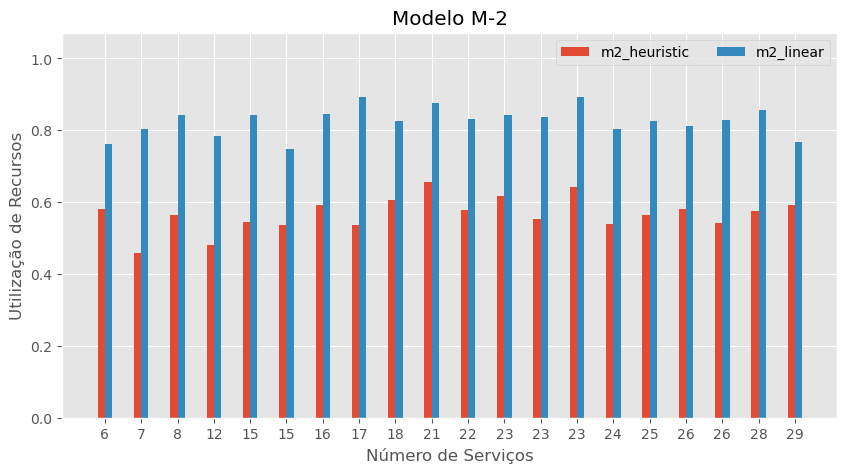

In [176]:
# plot_line_graph(df_nodes_utilization, 'Nodes Utilization for each application', ylabel='Nodes Utilization (%)')
plot_grouped_bar_chart(df_nodes_utilization, model+'_solution_nodes_utilization','Modelo '+sol[model], 'Número de Serviços', 'Utilização de Recursos')


In [177]:
print('nodes for each app'.upper())
display(df_nodes_for_app)

print('nodes for each app'.upper())
display(df_nodes_for_app.describe())

# print sum of a column
print('sum of nodes for each app'.upper())
display(df_nodes_for_app.sum())

NODES FOR EACH APP


,app,m2_heuristic,m2_linear
0,App11,4,3
1,App4,5,3
2,App6,6,4
3,App19,9,6
4,App12,10,7
5,App15,9,8
6,App16,10,8
7,App18,11,6
8,App7,10,9
9,App8,12,10


NODES FOR EACH APP


,m2_heuristic,m2_linear
count,20.000000,20.000000
mean,11.900000,9.050000
std,4.063962,3.440854
min,4.000000,3.000000
25%,9.750000,6.750000
50%,12.500000,9.500000
75%,15.000000,11.000000
max,19.000000,16.000000


SUM OF NODES FOR EACH APP


app             App11App4App6App19App12App15App16App18App7App8...
m2_heuristic                                                  238
m2_linear                                                     181
dtype: object

In [178]:
print('hops for each app'.upper())
display(df_hops_app)

print('hops for each app'.upper())
display(df_hops_app.describe())

HOPS FOR EACH APP


,app,m2_heuristic,m2_linear
0,App11,13.0,15.0
1,App4,13.0,14.0
2,App6,26.0,16.0
3,App19,44.0,40.0
4,App12,47.0,42.0
5,App15,49.0,43.0
6,App16,49.0,78.0
7,App18,59.0,42.0
8,App7,54.0,59.0
9,App8,71.0,74.0


HOPS FOR EACH APP


,m2_heuristic,m2_linear
count,20.000000,20.000000
mean,61.600000,65.150000
std,25.029246,29.796282
min,13.000000,14.000000
25%,48.500000,42.000000
50%,65.500000,75.000000
75%,84.500000,88.500000
max,98.000000,113.000000


In [179]:
print('Flow Time for each app'.upper())
display(df_latencies)

print('Flow Time for each app'.upper())
display(df_latencies.describe())

FLOW TIME FOR EACH APP


,app,m2_heuristic,m2_linear
0,App11,0.034420,0.031733
1,App4,0.063053,0.062500
2,App6,0.055007,0.034927
3,App19,0.152880,0.147233
4,App12,0.142020,0.131500
5,App15,0.105313,0.117633
6,App16,0.137933,0.209887
7,App18,0.173000,0.112473
8,App7,0.179433,0.201267
9,App8,0.235893,0.243327


FLOW TIME FOR EACH APP


,m2_heuristic,m2_linear
count,20.000000,20.000000
mean,0.181778,0.204803
std,0.072751,0.098217
min,0.034420,0.031733
25%,0.140998,0.128033
50%,0.203606,0.230714
75%,0.240355,0.256745
max,0.268980,0.362273


In [180]:

print('nodes utilization for each app'.upper())
display(df_nodes_utilization)
print('nodes utilization for each app'.upper())
display(df_nodes_utilization.describe())

NODES UTILIZATION FOR EACH APP


,app,m2_heuristic,m2_linear
0,App11,0.580212,0.762303
1,App4,0.457220,0.805021
2,App6,0.564834,0.842282
3,App19,0.479422,0.784820
4,App12,0.543764,0.843288
5,App15,0.536011,0.748549
6,App16,0.591981,0.845867
7,App18,0.537556,0.891690
8,App7,0.606664,0.825462
9,App8,0.655775,0.875235


NODES UTILIZATION FOR EACH APP


,m2_heuristic,m2_linear
count,20.000000,20.000000
mean,0.566744,0.825979
std,0.047553,0.039641
min,0.457220,0.748549
25%,0.541238,0.804732
50%,0.569729,0.829186
75%,0.592054,0.843933
max,0.655775,0.893028


In [181]:
# print date and time
import datetime
now = datetime.datetime.now()
print(now.strftime("%Y-%m-%d %H:%M:%S"))

2024-05-24 09:18:44


In [182]:
# import matplotlib.pyplot as plt

# # plotando gráfico de linhas
# def plot_line_graph(df, title, xlabel='Number of Services', ylabel='Number of Allocated Nodes'):
#     fig, ax = plt.subplots(figsize=(10,5))

#     number_data = len(dict_lines)
#     x = (0.98)
#     y = 1+(number_data * 0.3)/6
    
#     # marker different for each line
#     marker = ['o', 'v', 's', 'P', 'X', 'D', 'p', '*', 'h', 'H', 'd', '8', '>', '<', '^']
#     for key, values in dict_lines.items():
#         m = []
#         for k, v in values.items():
#             m.append(k)    
#         ax.plot(m, df[key], label=key, marker=marker.pop())
#         # ax.scatter(m, df[key], label=key)
    
#     ax.set(xlabel=xlabel, ylabel=ylabel,
#         title=title)
#     # plot all values in x axis
#     # ax.set_xticks(np.arange(min(m), max(m)+1, 4))


#     ax.grid()
#     ax.legend(ncol=3, bbox_to_anchor=(x, y))
#     plt.xticks(rotation=90)
#     plt.show()